## Import

In [1]:
import numpy as np
from stateinterpreter import Classifier, identify_metastable_states, load_dataframe, descriptors_from_traj, sample
from stateinterpreter.plot import plot_states
#Paranoia
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

/tmp/ipykernel_283968/3758183241.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


## Preprocessing

Load trajectory

In [2]:
chignolin_data_path = '../../../data/md_datasets/chignolin-unbiased/'
colvar_file = chignolin_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
stride = 100
#Load Collective Variables
colvar = load_dataframe(colvar_file, stride=stride).drop(['time'], axis=1)
#Compute descriptors
descriptors, feats_info = descriptors_from_traj(traj_dict, descriptors=['dihedrals','ca','hbonds_contacts'], stride=stride)

Computing CA distances
Computing Hydrogen bonds contacts
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (5248, 465)


Label states

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 4 local minima with selected populations:
	Basin 0 -> 955 configurations.
	Basin 1 -> 719 configurations.
	Basin 2 -> 673 configurations.
	Basin 3 -> 2364 configurations.


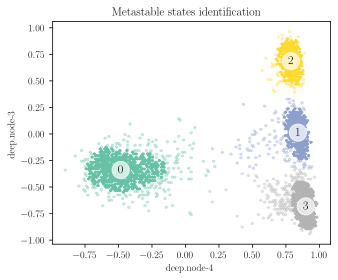

In [3]:
cv_list = ['deep.node-4', 'deep.node-3']
kBT = 2.8
states_labels = identify_metastable_states(colvar, cv_list, kBT, bw_method=0.07)
plot_states(colvar, states_labels, cv_list, fes_isolines=False);

## Group lasso

In [4]:
regularizers = np.geomspace(0.01, 1, 25)
select_feat = 'sin_|cos_'
states_names = [
    'Unfolded',
    'Folded Mid',
    'Folded High',
    'Folded Low'
]
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 500, regex_filter = select_feat, states_names=states_names)
groups = [feats_info[name]['group'] for name in features_names]
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000, groups=groups)

Optimizing Lasso Estimator: 100%|██████████| 25/25 [00:39<00:00,  1.56s/it]


Accuracy: 98%
State Unfolded:
[44.858%]  THR6
[36.6%  ]  ASP3
[14.612%]  THR8
[3.665% ]  TYR2
[0.266% ]  GLY7
State Folded Mid:
[48.182%]  THR6
[27.992%]  ASP3
[19.536%]  THR8
[3.988% ]  TYR2
[0.302% ]  GLY7
State Folded High:
[57.513%]  THR6
[41.074%]  THR8
[0.991% ]  ASP3
[0.341% ]  GLY7
[0.082% ]  TYR2
State Folded Low:
[59.039%]  THR6
[36.779%]  THR8
[3.528% ]  ASP3
[0.379% ]  TYR2
[0.276% ]  GLY7


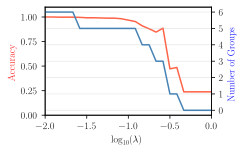

In [5]:
reg = 10**(-1.2)
classifier.print_selected(reg)
classifier.plot();

A note on the problem to solve:
1. For regular Lasso $$ \min_{w}C\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \Vert w \Vert_{1}$$
2. For _group_ Lasso $$ \min_{w} \frac{1}{n}\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \lambda \sum_{j}  \Vert w_{j} \Vert_{2}$$

To have everything consistent $C \mapsto (\lambda n)^{-1}$. I'll use $\lambda$ as regularization parameter.

## Standard Lasso

### H-bonds 

In [6]:
regularizers = np.geomspace(0.01, 1, 25)
select_feat = 'HB_CONT'
states_names = [
    'Unfolded',
    'Folded Mid',
    'Folded High',
    'Folded Low'
]
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 500, regex_filter = select_feat, states_names=states_names)

classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000)

Optimizing Lasso Estimator: 100%|██████████| 25/25 [01:37<00:00,  3.91s/it]


Accuracy: 85%
State Unfolded:
[83.086%]  HB_CONTACT TYR1-O -- TYR10-N
[16.65% ]  HB_CONTACT ASP3-N -- THR8-O
[0.264% ]  HB_CONTACT ASP3-O -- GLY7-N
State Folded Mid:
State Folded High:
[91.93% ]  HB_CONTACT THR8-OG1s -- TRP9-N
[8.07%  ]  HB_CONTACT THR8-OG1s -- TRP9-O
State Folded Low:
[100.0% ]  HB_CONTACT THR6-OG1s -- THR8-OG1s


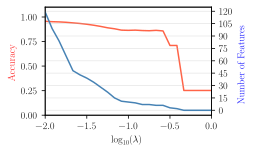

In [8]:
reg = 10**(-0.6)
classifier.print_selected(reg)
classifier.plot();

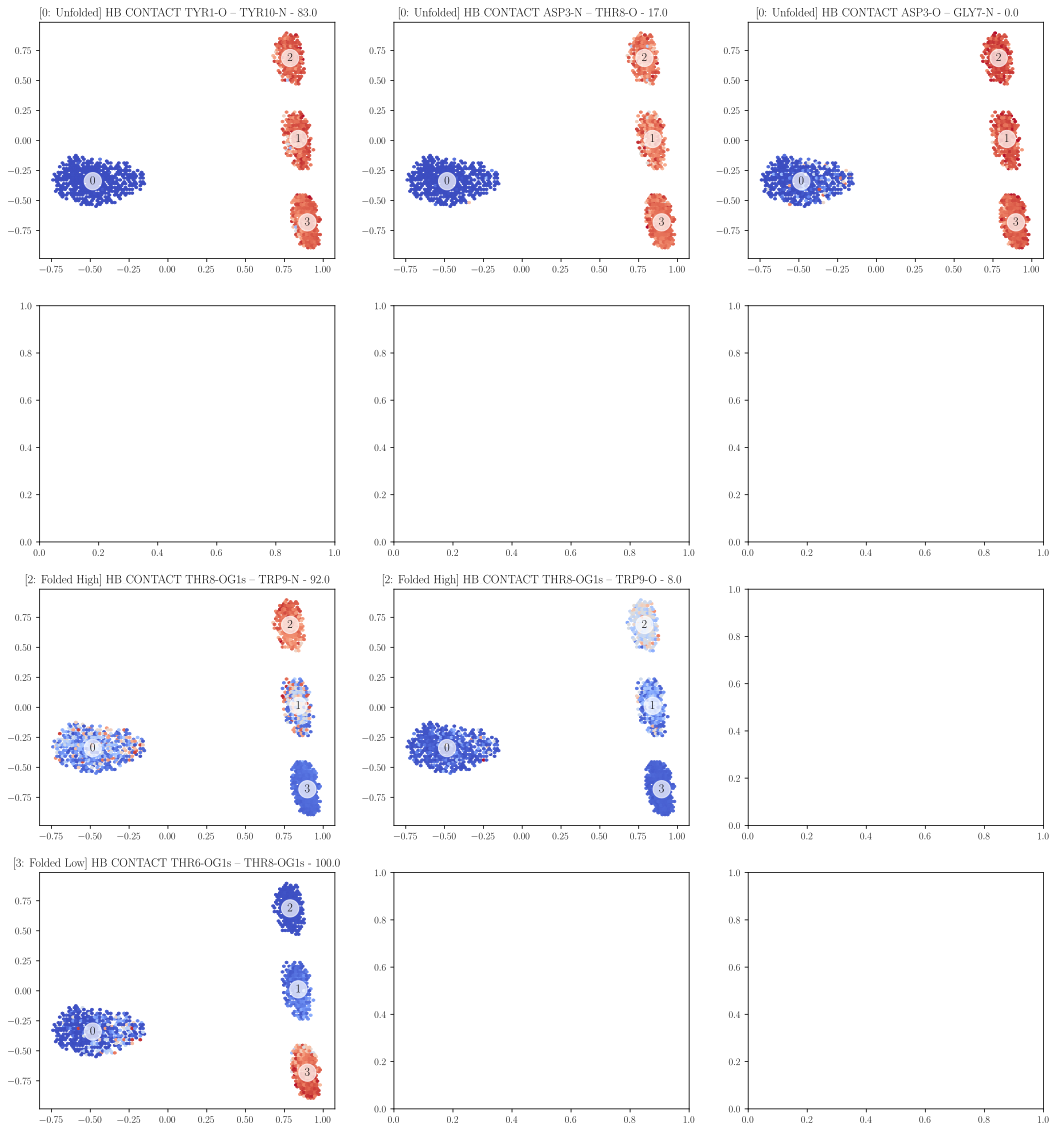

In [70]:
from stateinterpreter.plot import plot_combination_states_relevant_features

relevant_feat = classifier._get_selected(reg)

plot_combination_states_relevant_features(colvar,descriptors,cv_list,relevant_feat,state_labels=states_labels)